# Deliverables:
Base params: 4 NN inv distances with volume
Feature Testing:
1) Evaluate if including full distance information vs none affects performance.
2) Train on Multiple volume fractions (same N) then test on unseen volume fraction.
3) Evaluate if including n_particles as a feature between different particle simulation sizes improves performance.
4) Train on multiple volume fractions and N particles then test on unseen N particles.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import MLACDS as dt #diffusion simulation tools

pd.set_option('display.max_columns', 32)

In [5]:
def preprocess_data(df):
    """
    Function to scale and split data in a dataframe
    df: Dataframe, target var must be last column
    Returns: Scaled x train and test sets, y train and test sets as arrays
    """
    #getting training and target variable
    data = df.iloc[:,:-1] #all but last column
    target = df.iloc[:,-1:].values.ravel() #last column only
    #splitting to train and test data
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, random_state=13, test_size=0.4)
    #scaling data based on training set to prevent data leakage,
    #the scaler computed from training set statistics
    #will be applied to test data after sacling on train data as this info unknown
    scaler = preprocessing.StandardScaler().fit(X_train)
    #scale training data
    X_train_scaled = scaler.transform(X_train)
    #scale "unknown" test data
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def eval_model(test, prediction):
    """
    Function to evaluate rf regressor predictions
    test: testing data (y-test)
    prediction: model pred on test data = model.predict(x_test)
    Returns:r2, mae, mse, rmse
    """
    r2 = r2_score(test, prediction) #goodness of fit
    mae = mean_absolute_error(test, prediction) #mean abs error
    mse = mean_squared_error(test, prediction) #mean std error
    rmse = np.sqrt(mse) #root mean std error
    return r2, mae, mse, rmse


def bar_plot_metrics(models, r2_metric, mae_metric, mse_metric, rmse_metric):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), layout="constrained")
    
    axs[0][0].bar(models, r2_metric)
    axs[0][1].bar(models, mae_metric)
    axs[1][0].bar(models, mse_metric)
    axs[1][1].bar(models, rmse_metric)
    
    axs[0][0].set_title("R2 Score (Higher is Better)")
    axs[0][1].set_title("MAE (Lower is Better)")
    axs[1][0].set_title("MSE (Lower is Better)")
    axs[1][1].set_title("RMSE (Lower is Better)")
    
    plt.show()

def sort_list(list1, list2): #function from geeksforgeeks.org
    """
    This sorts one list from highest-lowest corresponding to values from another
    """
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs, reverse=True)]
    return z

def get_feat_importance(model, feat_names):
    #feature names =  training_dataframe.columns
    feat_imp = model.feature_importances_
    #rank highest to lowest
    ranked_feat_names = sort_list(feat_names, feat_imp) #rank feature names on imp
    ranked_feature_imp = sorted(feat_imp, reverse=True) #rank feat imp
    return ranked_feat_names, ranked_feature_imp

def plot_feat_imp(names, importance, model_name=""):
    fig, ax = plt.subplots(figsize=(18,4))
    ax.bar(names, importance)
    plt.title(f"Feature Importance for RF Model {model_name}")
    plt.show()

In [6]:
volfracs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
N_list = [54, 108]

for N_particles in N_list:
    for phi in volfracs:
        params = dt.findparams(phi, N_particles)

        print(f"phi:{phi}    n_particles:{N_particles}    req. boxsize: {params}")

print("\nUnseen Volume Fraction, Seen Num Particles")
params = dt.findparams(0.17, 54)
print(f"phi:{0.17}    n_particles:{54}    req. boxsize: {params}")

print("\nSeen Volume Fraction, Unseen Num Particles")
params = dt.findparams(0.2, 72)
print(f"phi:{0.2}    n_particles:{72}    req. boxsize: {params}")



phi:0.05    n_particles:54    req. boxsize: 8.269402402813594
phi:0.1    n_particles:54    req. boxsize: 6.563429036687327
phi:0.15    n_particles:54    req. boxsize: 5.733683388133033
phi:0.2    n_particles:54    req. boxsize: 5.209397078678045
phi:0.25    n_particles:54    req. boxsize: 4.835975862049408
phi:0.3    n_particles:54    req. boxsize: 4.550827520987483
phi:0.35    n_particles:54    req. boxsize: 4.322895918727637
phi:0.4    n_particles:54    req. boxsize: 4.134701201406797
phi:0.05    n_particles:108    req. boxsize: 10.41879415735609
phi:0.1    n_particles:108    req. boxsize: 8.269402402813594
phi:0.15    n_particles:108    req. boxsize: 7.223988394141365
phi:0.2    n_particles:108    req. boxsize: 6.563429036687327
phi:0.25    n_particles:108    req. boxsize: 6.092947785379555
phi:0.3    n_particles:108    req. boxsize: 5.733683388133033
phi:0.35    n_particles:108    req. boxsize: 5.446507564509587
phi:0.4    n_particles:108    req. boxsize: 5.209397078678045

Unseen 

In [9]:
test_files = ["p0.17_N54","p0.2_N72"]
filenames = [[],[]]
vc_filenames = []

for phi in volfracs:
    filenames[0].append(f"p{phi}_N54/")
    filenames[1].append(f"p{phi}_N108/")
    vc_filenames.append(f"VC{phi}_N72/")
print(filenames[0],"\n")
print(filenames[1],"\n")
print(test_files, "\n")



['p0.05_N54/', 'p0.1_N54/', 'p0.15_N54/', 'p0.2_N54/', 'p0.25_N54/', 'p0.3_N54/', 'p0.35_N54/', 'p0.4_N54/'] 

['p0.05_N108/', 'p0.1_N108/', 'p0.15_N108/', 'p0.2_N108/', 'p0.25_N108/', 'p0.3_N108/', 'p0.35_N108/', 'p0.4_N108/'] 

['p0.17_N54', 'p0.2_N72'] 

['VC0.05_N72/', 'VC0.1_N72/', 'VC0.15_N72/', 'VC0.2_N72/', 'VC0.25_N72/', 'VC0.3_N72/', 'VC0.35_N72/', 'VC0.4_N72/']


In [13]:
for phi in volfracs:
    params = dt.findparams(phi, 72)
    print(f"VC: phi:{phi}    n_particles:{72}    req. boxsize: {params}")

print("\n",vc_filenames)

VC: phi:0.05    n_particles:72    req. boxsize: 9.101655041974967
VC: phi:0.1    n_particles:72    req. boxsize: 7.223988394141365
VC: phi:0.15    n_particles:72    req. boxsize: 6.3107351386036425
VC: phi:0.2    n_particles:72    req. boxsize: 5.733683388133033
VC: phi:0.25    n_particles:72    req. boxsize: 5.322680157965874
VC: phi:0.3    n_particles:72    req. boxsize: 5.008833798856052
VC: phi:0.35    n_particles:72    req. boxsize: 4.757962609394053
VC: phi:0.4    n_particles:72    req. boxsize: 4.550827520987483

 ['VC0.05_N72/', 'VC0.1_N72/', 'VC0.15_N72/', 'VC0.2_N72/', 'VC0.25_N72/', 'VC0.3_N72/', 'VC0.35_N72/', 'VC0.4_N72/']


## Evaluate if including full distance information vs none affects performance.


In [ ]:
N_neighbours = 4 ### number of neighbours to be extracted

N54dires = ['p0.05_N54/', 'p0.1_N54/', 'p0.15_N54/', 'p0.2_N54/', 'p0.25_N54/', 'p0.3_N54/', 'p0.35_N54/', 'p0.4_N54/'] 
N108dires = ['p0.05_N108/', 'p0.1_N108/', 'p0.15_N108/', 'p0.2_N108/', 'p0.25_N108/', 'p0.3_N108/', 'p0.35_N108/', 'p0.4_N108/'] 

f_r_cut_vol = 4
f_r_cut_sp = 30

path="data/all_simulation_data/"


In [96]:
df = dt.get_data(path, N54dires, f_r_cut_vol, f_r_cut_sp,
                      N_neighbours, dist=False, dist_inv=True, bond_order=False, angular=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:90: RuntimeWarning: invalid value encountered in double_scalars
  angx = delta[0]/(R**2)
/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:91: RuntimeWarning: invalid value encountered in double_scalars
  angy = delta[1]/(R**2)
/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:92: RuntimeWarning: invalid value encountered in double_scalars
  angz = delta[2]/(R**2)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
df

,l0_inv,l1_inv,l2_inv,l3_inv,l0_x_inv,l1_x_inv,l2_x_inv,l3_x_inv,l0_y_inv,l1_y_inv,l2_y_inv,l3_y_inv,l0_z_inv,l1_z_inv,l2_z_inv,l3_z_inv,vol,n_neighbours,n_particles,Ds
0,0.807525,0.715806,0.620141,0.510357,0.166687,0.142562,0.136061,0.118131,0.195034,0.112562,-0.000000,-0.002481,0.324970,0.267418,0.247729,0.234065,0.074661,53.0,54.0,0.632004
1,0.474384,0.468391,0.456727,0.453382,0.266359,0.251918,0.243975,0.236523,-0.009327,-0.010513,-0.014081,-0.018640,0.293386,0.290617,0.248014,0.170227,0.031458,53.0,54.0,0.696140
2,0.690373,0.656742,0.554466,0.492246,0.462951,0.380678,0.366478,0.266970,0.254255,0.225019,0.210274,0.197469,0.401479,0.283175,0.249968,0.201029,0.072577,53.0,54.0,0.660416
3,0.769720,0.656742,0.620990,0.488805,0.237983,0.235994,0.213615,0.198557,0.311616,0.278631,0.244312,0.232473,0.400974,0.316731,0.230456,0.221333,0.072038,53.0,54.0,0.647287
4,0.678388,0.495193,0.464708,0.391625,0.222751,0.213615,0.193306,0.176317,0.231947,0.225019,0.203825,0.196417,0.225000,0.220327,0.196106,0.146649,0.041686,53.0,54.0,0.682537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,0.936663,0.910138,0.878332,0.876980,0.436472,0.385766,0.370489,0.297361,0.334322,0.330967,0.226304,-0.000000,0.544063,0.480497,0.462156,0.430408,0.386924,53.0,54.0,0.189674
43196,0.907321,0.901353,0.884903,0.878444,-0.022306,-0.031086,-0.038323,-0.045651,-0.026624,-0.032100,-0.041969,-0.054871,0.710153,0.590906,0.403742,0.394613,0.379571,53.0,54.0,0.182819
43197,0.935640,0.907321,0.858578,0.843887,0.677169,0.505505,0.436472,0.351716,0.243372,-0.000000,-0.047882,-0.053732,0.492917,0.471456,0.429180,0.402890,0.380252,53.0,54.0,0.201721
43198,0.916293,0.915564,0.910441,0.907556,0.398990,0.241863,0.236556,0.177225,0.512825,0.467171,0.420147,0.376479,0.627440,0.527116,0.421343,0.411209,0.406698,53.0,54.0,0.178886


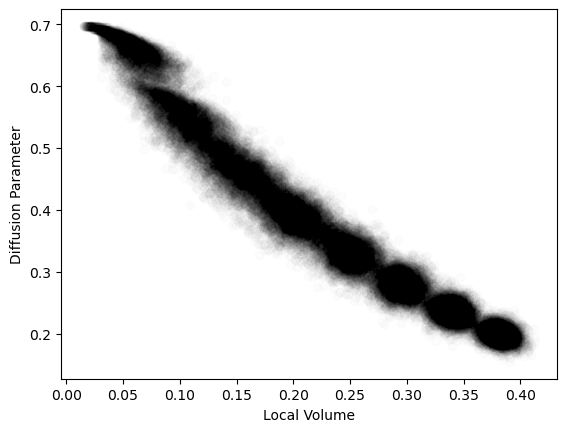

In [95]:
plt.scatter(df.vol, df.Ds, c="k", alpha=0.01)
plt.xlabel("Local Volume")
plt.ylabel("Diffusion Parameter")
plt.show()

In [56]:
dist_df = df[["l0_inv", "l1_inv", "l2_inv", "l3_inv", "vol", "n_neighbours", "n_particles", "Ds"]]

full_dist_df = df

part_dist_df = df.drop(["l0_inv", "l1_inv", "l2_inv", "l3_inv"], axis=1)

In [111]:
dist_xtrain, dist_xtest, ytrain, ytest, _ = preprocess_data(dist_df)
full_dist_xtrain, full_dist_xtest, ytrain, ytest, model_scaler = preprocess_data(full_dist_df)
part_dist_xtrain, part_dist_xtest, ytrain, ytest, _ = preprocess_data(part_dist_df)


In [59]:
dist_model = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)
full_dist_model = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)
part_dist_model = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)


In [60]:
dist_model.fit(dist_xtrain, ytrain)
full_dist_model.fit(full_dist_xtrain, ytrain)
part_dist_model.fit(part_dist_xtrain, ytrain)


RandomForestRegressor(max_depth=14, n_estimators=300)

In [61]:
dist_preds = dist_model.predict(dist_xtest)
full_dist_preds = full_dist_model.predict(full_dist_xtest)
part_dist_preds = part_dist_model.predict(part_dist_xtest)

In [62]:
dist_metrics = eval_model(ytest, dist_preds)
full_dist_metrics = eval_model(ytest, full_dist_preds)
part_dist_metrics = eval_model(ytest, part_dist_preds)

In [67]:
print("                           R2,                MAE,                  MSE,                 RMSE")
print("Radial Dist            ", dist_metrics)
print("Radial and Angular Dist", full_dist_metrics)
print("Angular Dist           ", part_dist_metrics)

                           R2,                MAE,                  MSE,                 RMSE
Radial Dist             (0.9898780287088698, 0.00980922250399346, 0.00022694062053549906, 0.015064548467693914)
Radial and Angular Dist (0.9920214456657023, 0.008861488125264137, 0.000178883936688139, 0.013374749967312995)
Angular Dist            (0.9755199733325473, 0.017759640945545753, 0.0005488567674071053, 0.023427692319285424)


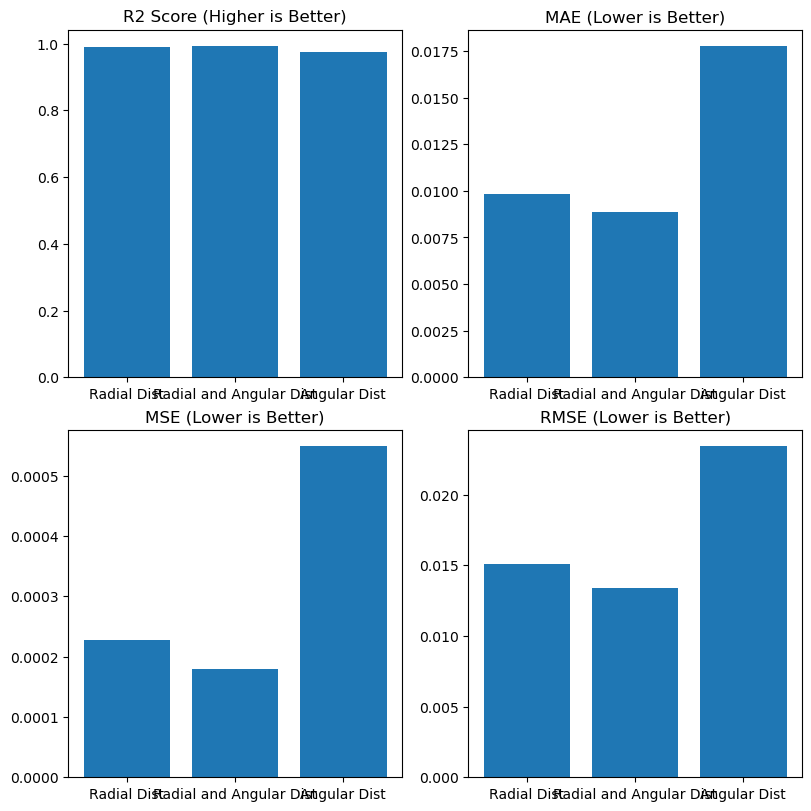

In [68]:
models = ["Radial Dist", "Radial and Angular Dist", "Angular Dist"]

r2_metric = [dist_metrics[0], full_dist_metrics[0], part_dist_metrics[0]]
mae_metric = [dist_metrics[1], full_dist_metrics[1], part_dist_metrics[1]]
mse_metric = [dist_metrics[2], full_dist_metrics[2], part_dist_metrics[2]]
rmse_metric = [dist_metrics[3], full_dist_metrics[3], part_dist_metrics[3]]

bar_plot_metrics(models, r2_metric, mae_metric, mse_metric, rmse_metric)

In [79]:
dist_names, dist_imp = get_feat_importance(dist_model, dist_df.columns[:-1])
full_dist_names, full_dist_imp = get_feat_importance(full_dist_model, full_dist_df.columns[:-1])
part_dist_names, part_dist_imp = get_feat_importance(part_dist_model, part_dist_df.columns[:-1])

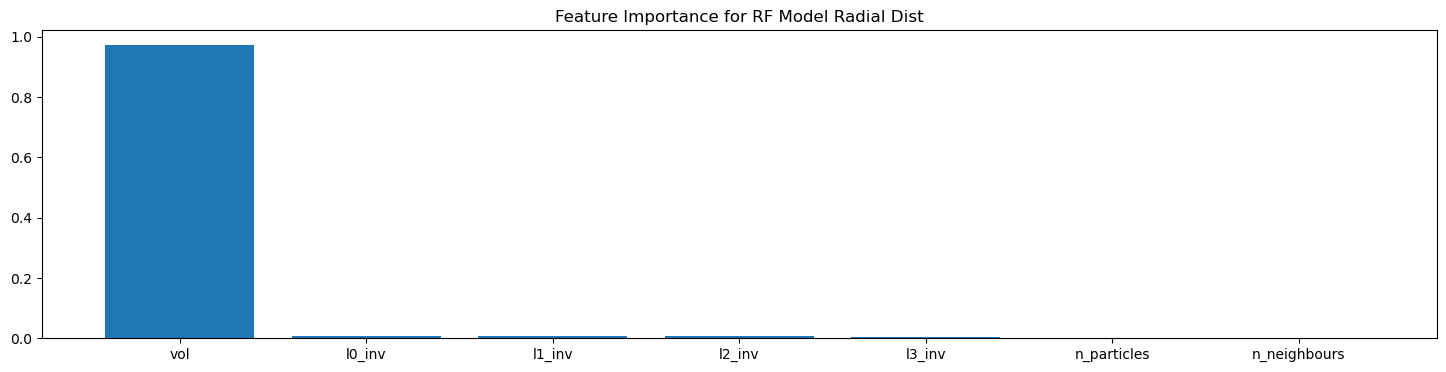

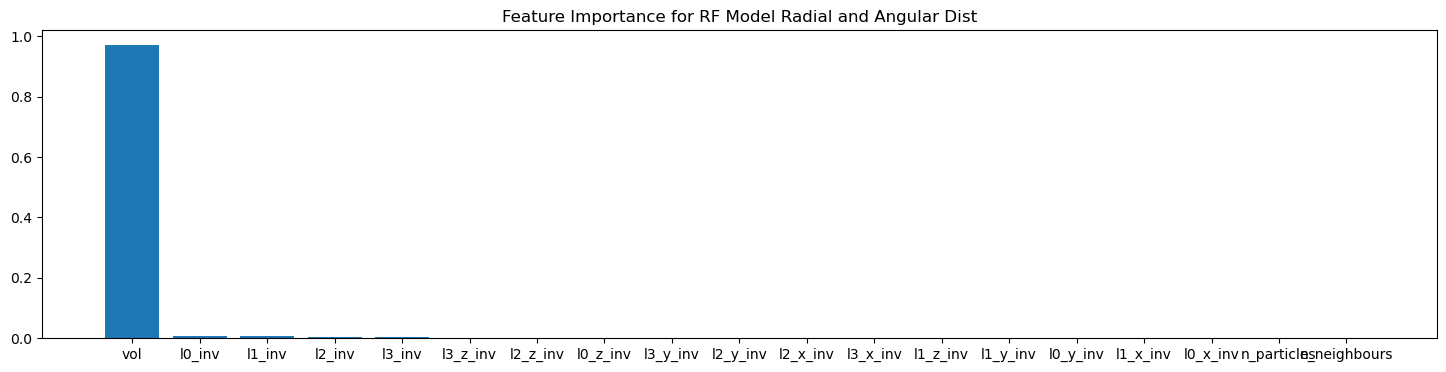

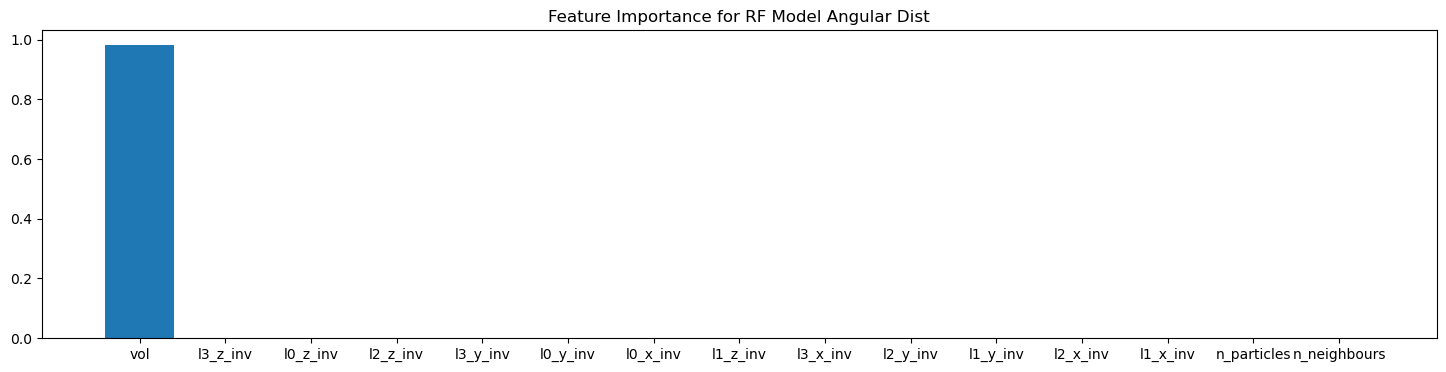

In [82]:
plot_feat_imp(dist_names, dist_imp, model_name=models[0])
plot_feat_imp(full_dist_names, full_dist_imp, model_name=models[1])
plot_feat_imp(part_dist_names, part_dist_imp, model_name=models[2])


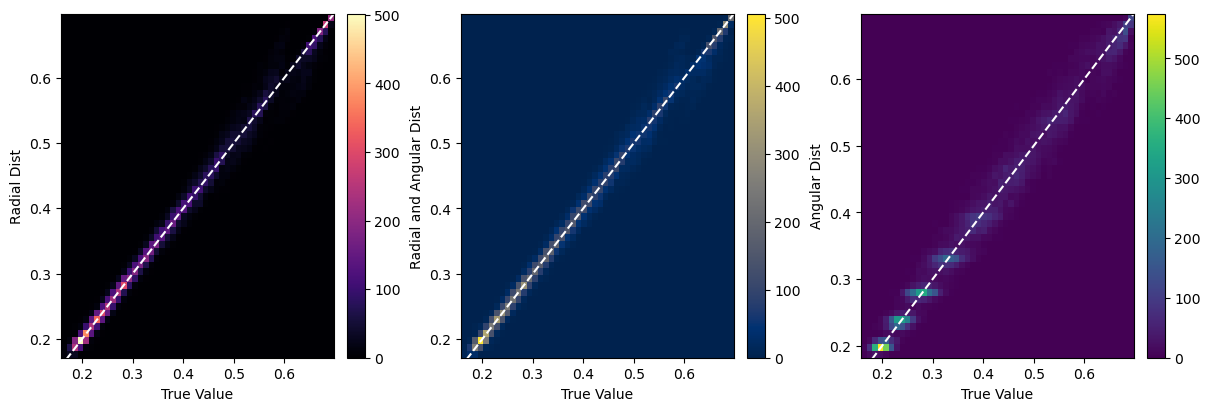

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), layout="constrained")#, sharex=True, sharey=True)

im0 = axs[0].hist2d(ytest, dist_preds, bins=50, cmap="magma")
im1 = axs[1].hist2d(ytest, full_dist_preds, bins=50, cmap="cividis")
im2 = axs[2].hist2d(ytest, part_dist_preds, bins=50)

axs[0].plot([0,1],[0,1], "w--")
axs[1].plot([0,1],[0,1], "w--")
axs[2].plot([0,1],[0,1], "w--")

fig.colorbar(im0[3], ax=axs[0])
fig.colorbar(im1[3], ax=axs[1])
fig.colorbar(im2[3], ax=axs[2])

axs[0].set_xlabel("True Value")
axs[0].set_ylabel(models[0])

axs[1].set_xlabel("True Value")
axs[1].set_ylabel(models[1])

axs[2].set_xlabel("True Value")
axs[2].set_ylabel(models[2])

plt.show()

## Train on Multiple volume fractions (same N) then test on unseen volume fraction.

Using full_dist model as this had the least error and best performance.

In [100]:
N_neighbours = 4 ### number of neighbours to be extracted

dires = ["p0.17_N54/"]

f_r_cut_vol = 4
f_r_cut_sp = 30

path="data/all_simulation_data/"


In [101]:
df = dt.get_data(path, dires, f_r_cut_vol, f_r_cut_sp,
                      N_neighbours, dist=False, dist_inv=True, bond_order=False, angular=True)


  0%|          | 0/100 [00:00<?, ?it/s]

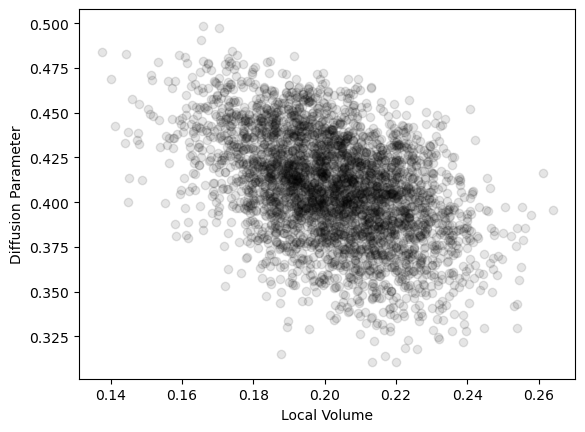

In [229]:
plt.scatter(df.vol, df.Ds, c="k", alpha=0.1)
plt.xlabel("Local Volume")
plt.ylabel("Diffusion Parameter")
plt.show()

In [112]:
unseen_xtest_unscaled = df.drop("Ds", axis=1)
unseen_ytest = df.Ds

unseen_xtest = model_scaler.transform(unseen_xtest_unscaled)

In [132]:
unseen_volfrac_model_preds = full_dist_model.predict(unseen_xtest)
unseen_volfrac_VC_preds = dt.VolumeCorrection(unseen_xtest_unscaled.vol)

In [133]:
unseen_volfrac_model_metrics = eval_model(unseen_ytest, unseen_volfrac_model_preds)
unseen_volfrac_VC_metrics = eval_model(unseen_ytest, unseen_volfrac_VC_preds)

In [122]:
unseen_volfrac_metrics

(0.7202740824800127,
 0.012343500187907936,
 0.00022108828565179365,
 0.014869037818628132)

In [134]:
unseen_volfrac_VC_metrics

(0.02213790486098055,
 0.022558592105787274,
 0.0007728774513813477,
 0.027800673577835264)

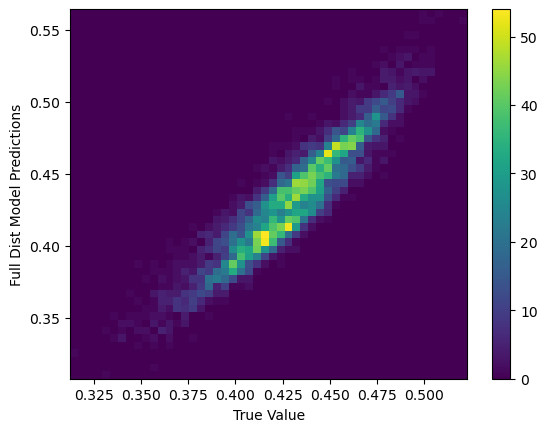

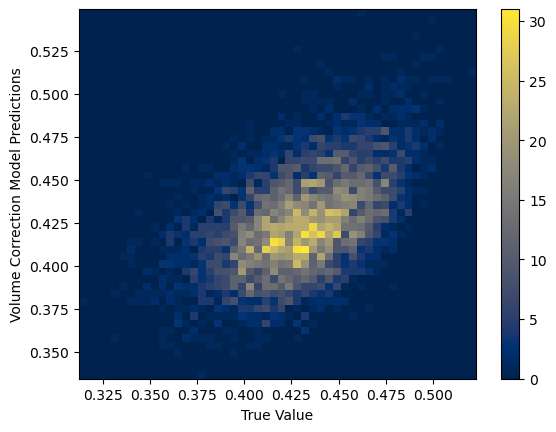

In [136]:
plt.hist2d(unseen_ytest, unseen_volfrac_preds, bins=50)
plt.colorbar()
plt.xlabel("True Value")
plt.ylabel("Full Dist Model Predictions")
plt.show()

plt.hist2d(unseen_ytest, unseen_volfrac_VC_preds, bins=50, cmap="cividis")
plt.colorbar()
plt.xlabel("True Value")
plt.ylabel("Volume Correction Model Predictions")
plt.show()

## Evaluate if including n_particles as a feature between different particle simulation sizes improves performance.

In [140]:
N_neighbours = 4 ### number of neighbours to be extracted

N54dires = ['p0.05_N54/', 'p0.1_N54/', 'p0.15_N54/', 'p0.2_N54/', 'p0.25_N54/', 'p0.3_N54/', 'p0.35_N54/', 'p0.4_N54/'] 
N108dires = ['p0.05_N108/', 'p0.1_N108/', 'p0.15_N108/', 'p0.2_N108/', 'p0.25_N108/', 'p0.3_N108/', 'p0.35_N108/', 'p0.4_N108/'] 

f_r_cut_vol = 4
f_r_cut_sp = 30

path="data/all_simulation_data/"

In [141]:
N54dires + N108dires

['p0.05_N54/',
 'p0.1_N54/',
 'p0.15_N54/',
 'p0.2_N54/',
 'p0.25_N54/',
 'p0.3_N54/',
 'p0.35_N54/',
 'p0.4_N54/',
 'p0.05_N108/',
 'p0.1_N108/',
 'p0.15_N108/',
 'p0.2_N108/',
 'p0.25_N108/',
 'p0.3_N108/',
 'p0.35_N108/',
 'p0.4_N108/']

In [142]:
df_2 = dt.get_data(path, N54dires + N108dires, f_r_cut_vol, f_r_cut_sp,
                      N_neighbours, dist=False, dist_inv=True, bond_order=False, angular=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [147]:
df_2 = df_2.drop("n_neighbours", axis=1)

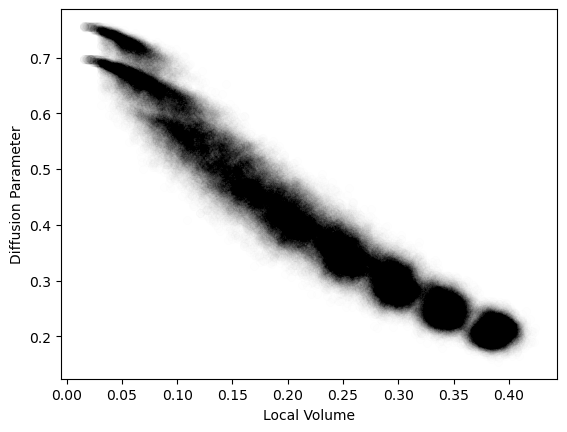

In [227]:
plt.scatter(df_2.vol, df_2.Ds, c="k", alpha=0.005)
plt.xlabel("Local Volume")
plt.ylabel("Diffusion Parameter")
plt.show()

In [148]:
df_2.head()

,l0_inv,l1_inv,l2_inv,l3_inv,l0_x_inv,l1_x_inv,l2_x_inv,l3_x_inv,l0_y_inv,l1_y_inv,l2_y_inv,l3_y_inv,l0_z_inv,l1_z_inv,l2_z_inv,l3_z_inv,vol,n_particles,Ds
0,0.807525,0.715806,0.620141,0.510357,0.166687,0.142562,0.136061,0.118131,0.195034,0.112562,-0.000000,-0.002481,0.324970,0.267418,0.247729,0.234065,0.074661,54.0,0.632004
1,0.474384,0.468391,0.456727,0.453382,0.266359,0.251918,0.243975,0.236523,-0.009327,-0.010513,-0.014081,-0.018640,0.293386,0.290617,0.248014,0.170227,0.031458,54.0,0.696140
2,0.690373,0.656742,0.554466,0.492246,0.462951,0.380678,0.366478,0.266970,0.254255,0.225019,0.210274,0.197469,0.401479,0.283175,0.249968,0.201029,0.072577,54.0,0.660416
3,0.769720,0.656742,0.620990,0.488805,0.237983,0.235994,0.213615,0.198557,0.311616,0.278631,0.244312,0.232473,0.400974,0.316731,0.230456,0.221333,0.072038,54.0,0.647287
4,0.678388,0.495193,0.464708,0.391625,0.222751,0.213615,0.193306,0.176317,0.231947,0.225019,0.203825,0.196417,0.225000,0.220327,0.196106,0.146649,0.041686,54.0,0.682537


In [166]:
num_df = df_2
no_num_df = df_2.drop("n_particles", axis=1)

In [186]:
num_xtrain, num_xtest, ytrain, ytest, num_neighbour_scaler = preprocess_data(num_df)
no_num_xtrain, no_num_xtest, ytrain, ytest, _ = preprocess_data(no_num_df)


In [168]:
num_model = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)
no_num_model = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)


In [169]:
num_model.fit(num_xtrain, ytrain)
no_num_model.fit(no_num_xtrain, ytrain)


RandomForestRegressor(max_depth=14, n_estimators=300)

In [170]:
num_preds = num_model.predict(num_xtest)
no_num_preds = no_num_model.predict(no_num_xtest)


In [171]:
num_metrics = eval_model(ytest, num_preds)
no_num_metrics = eval_model(ytest, no_num_preds)


In [172]:
print(num_metrics)

(0.9926536162598173, 0.009177783444433662, 0.00018156308614734805, 0.013474534728418197)


In [173]:
print(no_num_metrics)

(0.9758656472767554, 0.02011700530731266, 0.0005964713684411969, 0.02442276332525042)


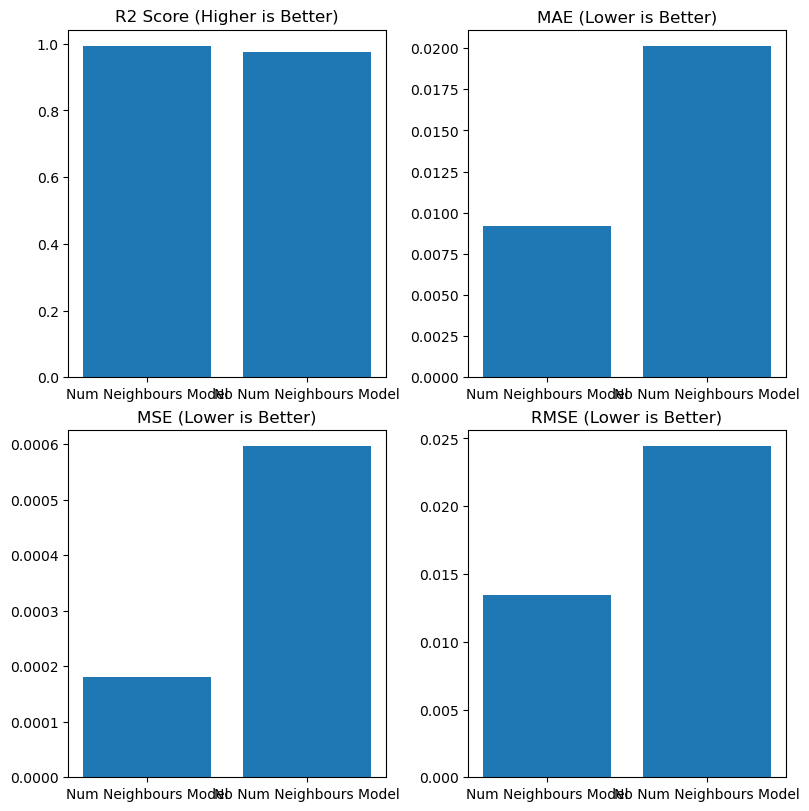

In [178]:
models2 = ["Num Neighbours Model", "No Num Neighbours Model"]

r2_metric = [num_metrics[0], no_num_metrics[0]]
mae_metric = [num_metrics[1], no_num_metrics[1]]
mse_metric = [num_metrics[2], no_num_metrics[2]]
rmse_metric = [num_metrics[3], no_num_metrics[3]]

bar_plot_metrics(models2, r2_metric, mae_metric, mse_metric, rmse_metric)

In [179]:
num_names, num_imp = get_feat_importance(num_model, num_df.columns[:-1])
no_num_names, no_num_imp = get_feat_importance(no_num_model, no_num_df.columns[:-1])


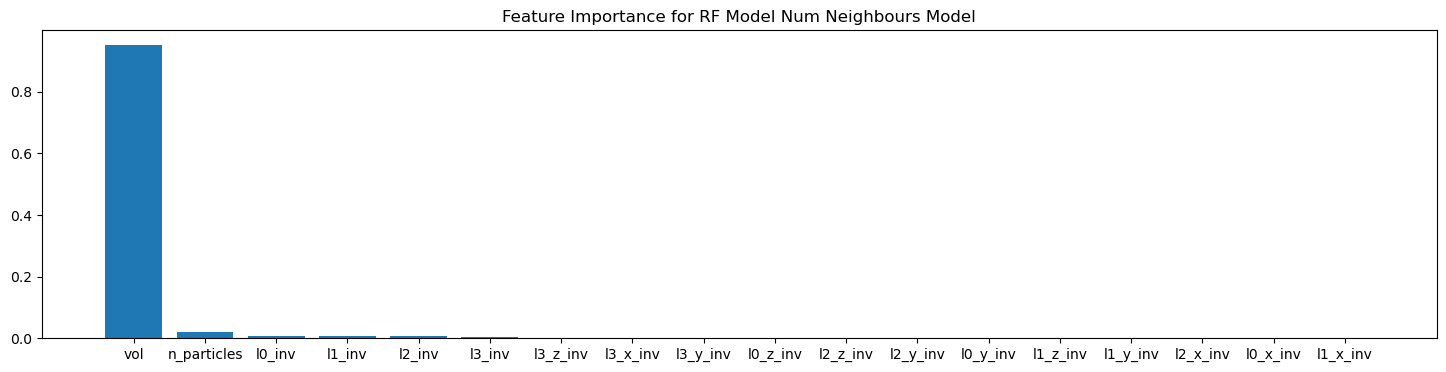

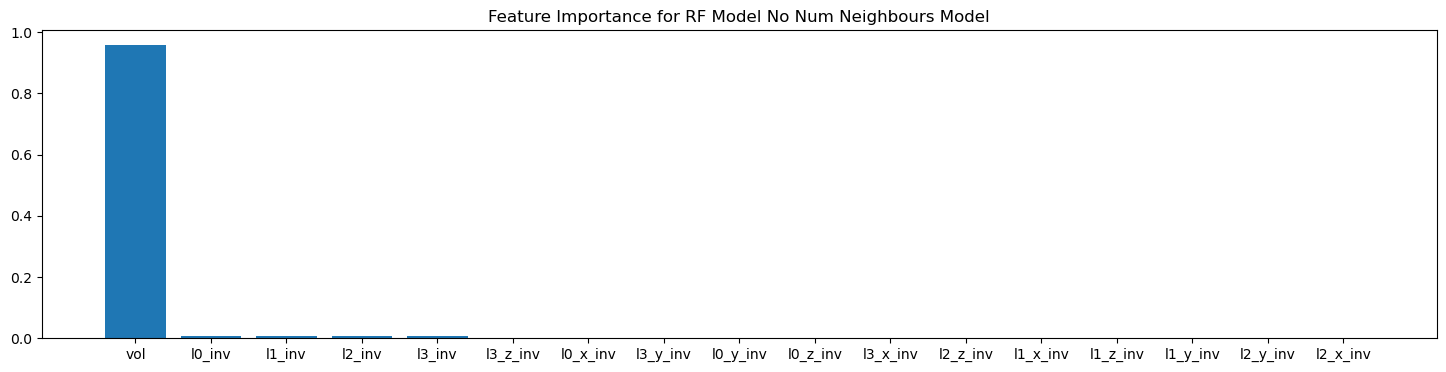

In [180]:
plot_feat_imp(num_names, num_imp, model_name=models2[0])
plot_feat_imp(no_num_names, no_num_imp, model_name=models2[1])


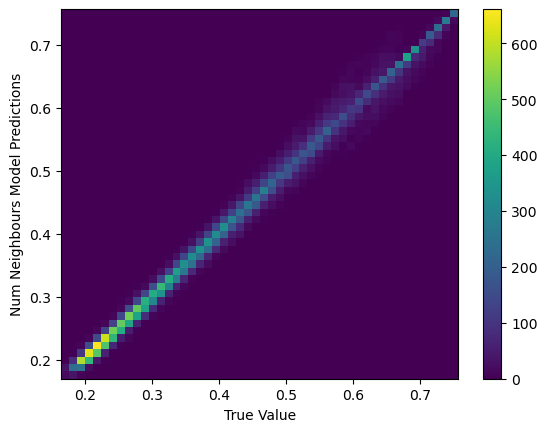

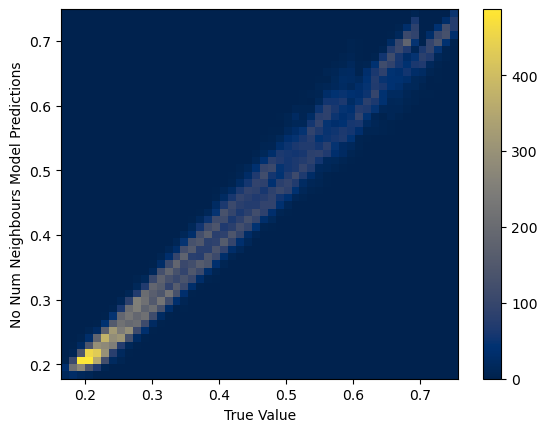

In [181]:
plt.hist2d(ytest, num_preds, bins=50)
plt.colorbar()
plt.xlabel("True Value")
plt.ylabel("Num Neighbours Model Predictions")
plt.show()

plt.hist2d(ytest, no_num_preds, bins=50, cmap="cividis")
plt.colorbar()
plt.xlabel("True Value")
plt.ylabel("No Num Neighbours Model Predictions")
plt.show()

## Train on multiple volume fractions and N particles then test on unseen N particles.

In [15]:
N_neighbours = 4 ### number of neighbours to be extracted

dires = ["p0.2_N72/"]

f_r_cut_vol = 4
f_r_cut_sp = 30

path="data/all_simulation_data/"


In [16]:
df = dt.get_data(path, dires, f_r_cut_vol, f_r_cut_sp,
                      N_neighbours, dist=False, dist_inv=True, bond_order=False, angular=True)


  0%|          | 0/50 [00:00<?, ?it/s]

/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:90: RuntimeWarning: invalid value encountered in double_scalars
  angx = delta[0]/(R**2)
/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:91: RuntimeWarning: invalid value encountered in double_scalars
  angy = delta[1]/(R**2)
/home/richard/Work/4th_Year_College/final_year_project/MLACDS/MLACDS.py:92: RuntimeWarning: invalid value encountered in double_scalars
  angz = delta[2]/(R**2)


In [207]:
unseen_nparticles_xtest_unscaled_fulldistmodel = df.drop("Ds", axis=1)
unseen_nparticles_xtest_fulldistmodel = model_scaler.transform(unseen_nparticles_xtest_unscaled_fulldistmodel)

unseen_nparticles_xtest_unscaled = df.drop(["Ds", "n_neighbours"], axis=1)
unseen_nparticles_ytest = df.Ds

unseen_nparticles_xtest = num_neighbour_scaler.transform(unseen_nparticles_xtest_unscaled)


In [218]:
unseen_nparticles_num_model_preds = num_model.predict(unseen_nparticles_xtest)

unseen_nparticles_fulldist_model_preds = full_dist_model.predict(unseen_nparticles_xtest_fulldistmodel)

unseen_nparticles_VC_preds = dt.VolumeCorrection(unseen_nparticles_xtest_unscaled.vol)


In [216]:
unseen_nparticles_num_model_metrics = eval_model(unseen_nparticles_ytest, unseen_nparticles_num_model_preds)

unseen_nparticles_fulldistmodel_metrics = eval_model(unseen_nparticles_ytest, unseen_nparticles_fulldist_model_preds)

unseen_nparticles_VC_metrics = eval_model(unseen_nparticles_ytest, unseen_nparticles_VC_preds)
                                          

In [213]:
unseen_nparticles_num_model_metrics

(0.49195401088817825,
 0.018700290899687166,
 0.00044654079012153866,
 0.021131511780313746)

In [215]:
unseen_nparticles_fulldistmodel_metrics

(0.48410524407112965,
 0.01893199480385465,
 0.00045343936743752483,
 0.021294115793747456)

In [214]:
unseen_nparticles_VC_metrics

(-0.3550594990486553,
 0.028271391290275054,
 0.0011910129246856462,
 0.03451105510826417)

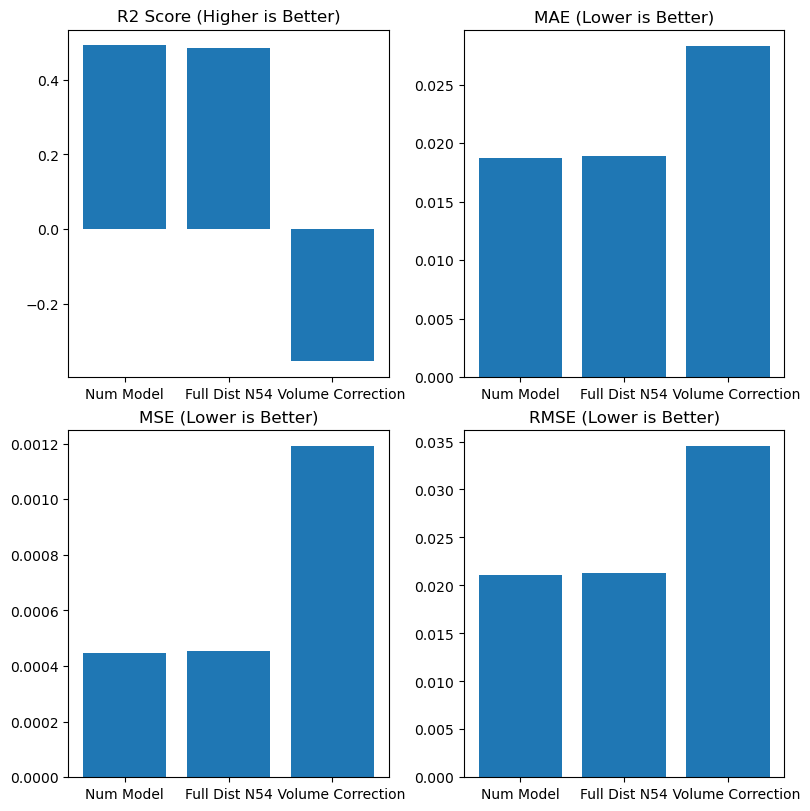

In [225]:
models2 = ["Num Model", "Full Dist N54", "    Volume Correction"]

r2_metric = [unseen_nparticles_num_model_metrics[0], unseen_nparticles_fulldistmodel_metrics[0], unseen_nparticles_VC_metrics[0]]
mae_metric = [unseen_nparticles_num_model_metrics[1], unseen_nparticles_fulldistmodel_metrics[1], unseen_nparticles_VC_metrics[1]]
mse_metric = [unseen_nparticles_num_model_metrics[2], unseen_nparticles_fulldistmodel_metrics[2], unseen_nparticles_VC_metrics[2]]
rmse_metric = [unseen_nparticles_num_model_metrics[3], unseen_nparticles_fulldistmodel_metrics[3], unseen_nparticles_VC_metrics[3]]

bar_plot_metrics(models2, r2_metric, mae_metric, mse_metric, rmse_metric)

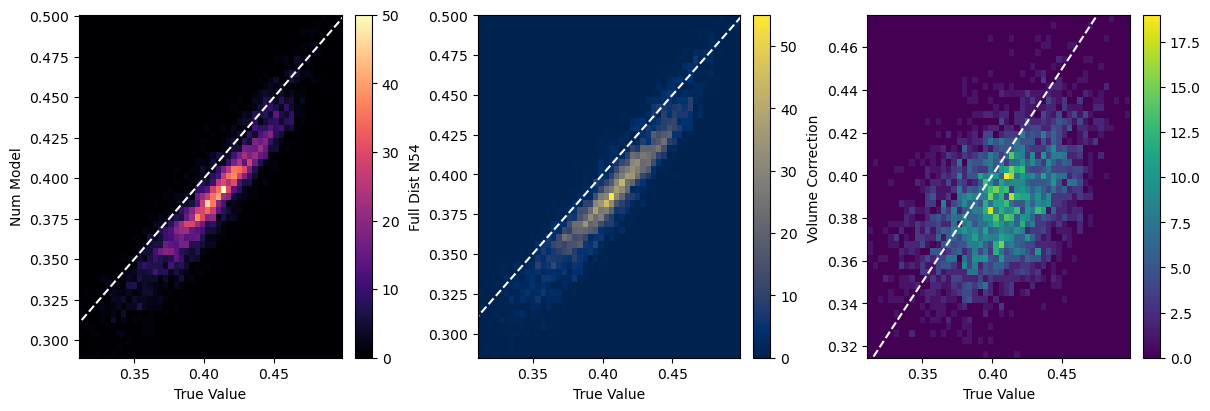

In [226]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), layout="constrained")#, sharex=True, sharey=True)

im0 = axs[0].hist2d(unseen_nparticles_ytest, unseen_nparticles_num_model_preds, bins=50, cmap="magma")
im1 = axs[1].hist2d(unseen_nparticles_ytest, unseen_nparticles_fulldist_model_preds, bins=50, cmap="cividis")
im2 = axs[2].hist2d(unseen_nparticles_ytest, unseen_nparticles_VC_preds, bins=50)

axs[0].plot([0,1],[0,1], "w--")
axs[1].plot([0,1],[0,1], "w--")
axs[2].plot([0,1],[0,1], "w--")

fig.colorbar(im0[3], ax=axs[0])
fig.colorbar(im1[3], ax=axs[1])
fig.colorbar(im2[3], ax=axs[2])

axs[0].set_xlabel("True Value")
axs[0].set_ylabel(models2[0])

axs[1].set_xlabel("True Value")
axs[1].set_ylabel(models2[1])

axs[2].set_xlabel("True Value")
axs[2].set_ylabel(models2[2])

plt.show()

## Conclusions:

1) Including radial and angular distance features improves performance slightly, there is low associated cost for including these in the features.
2) Models trained over a range of volume fractions predict unseen volume fractions with greater accuracy compared to the standard volume correction method. However these model predictions on unseen volume fractions are less accurate than those of seen volume fractions.
3) Including N particle feature improves performance on models making predictions on data in the training featurespace very very slightly compared to those without. However there is low associated cost with including this feature.
4) When testing these models on unseen number particle data they perform significantly better compared to the Volume correction method. But difference in performance between models trained on N=54 and N=54, 108 particles is not large when testing on test sets of N=72.

## Reccomendations
1) See how the performance of models change as you get further from seen volume fractions from training sets. Between seen volume fractions and past a seen volume fraction.
2) See how the performance of models change as you gradually increase the number of particles further from the number in the training set.
3) See how the model trained on N=54, 108 data performs on predicting data featuring only N=54 particles(Due to the small difference of performance on N=72 testing they will likely perform similarly).
4) See how the Local Volume vs Diffusion Parameter Plot Changes as N Particles Increase.

In [1]:
#Cubic spline for 72 particles.